## importing libraries 

In [7]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
#from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
from torchvision import datasets
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

## if model is already ran before then run the fifth and sixth cell and then this cell and finally last cell

In [8]:
 #if model saved
import os
import torch
import pickle
ran_before = True
if (ran_before):
    #model trained
    mask_detector_cnn = pickle.load(open("mask_dataset\maskdetectorcnn.pkl", 'rb'))
    
    #for mask dataset
    maskDF = pickle.load(open('mask_dataset\maskDF.pickle', 'rb'))
    
    #validate dfs
    validate_dfs = pickle.load(open('mask_dataset\validate_dfs.pickle', 'rb'))


    #for dataloader
    dataloader = pickle.load(open("mask_dataset\dataloader.pkl", 'rb'))

    

## opening all the mask images folder and making a new dataframe

In [9]:
from pathlib import Path
IMG_SIZE = 50
#datasetPath = Path('mask_dataset/')
CLOTH = "mask_dataset/Cloth mask/"
N95MASK = "mask_dataset/n95_mask/"
SURGICAL = "mask_dataset/surgical_mask/"
WITHOUT = "mask_dataset/no_mask/"
N95VALVE = "mask_dataset/n95_valve/"
#TESTING = "Dataset/Test"
maskDF = pd.DataFrame()
LABELS = {CLOTH: 0, N95MASK: 1, SURGICAL: 2, WITHOUT: 3, N95VALVE : 4}
training_data = []

### storing all the images of different folders into the maskDF dataframe

In [10]:
for label in LABELS:
    for f in tqdm(os.listdir(label)):
        path = os.path.join(label, f)
        #print(path)
        maskDF = maskDF.append(
        {
            "image": str(path),
            "mask": LABELS[label]
        }, ignore_index = True)

100%|███████████████████████████████████████████████████████████████████████████████| 900/900 [00:01<00:00, 509.00it/s]


## saving the dataframe into pickle format

In [11]:
dftrain = 'mask_dataset/maskDF.pickle'
print(f'Saving Dataframe to: {dftrain}')
maskDF.to_pickle(dftrain)

Saving Dataframe to: mask_dataset/maskDF.pickle


## preprocessing all our datas

In [12]:
from PIL import Image
import numpy as np
from torch import long, tensor
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

class MaskDetectionDataset(Dataset):
    def __init__(self, dataFrame):
        self.dataFrame = dataFrame
        self.transformations = Compose([
            Resize((32, 32)),
            ToTensor(),
            Normalize((0.5667, 0.5198, 0.4955),(0.3082, 0.2988, 0.3053))  #mean, std dev
        ])
    
    def __getitem__(self, key):
        
        row = self.dataFrame.iloc[key]
        image = Image.open(row['image']).convert('RGB')
        return {
          'image': self.transformations(image),
          'mask': tensor([row['mask']], dtype=long),
          'path': row['image']
        }
    
    def __len__(self):
        return len(self.dataFrame.index)

## used CNN using pytorch

In [13]:
import torch
import torch.nn.init as init
import torch.nn as nn
from torch import Tensor
from torch.nn import Conv2d
from torch.nn import CrossEntropyLoss 
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import Sequential
from torch.nn import functional
                      
class MaskDetectorCNN(nn.Module):
    def __init__(self):
        super(MaskDetectorCNN, self).__init__()
        super().__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(8 * 8 * 128, 1600), 
            nn.ReLU(inplace=True),
            nn.Linear(1600, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 5)
        )
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x
    
    
mask_detector_cnn = MaskDetectorCNN()
print(mask_detector_cnn)    

MaskDetectorCNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.01, inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01, inplac

## splitting our dataset into train and test set and plotting of confusion matrix

In [16]:
from pathlib import Path
from typing import Dict, List, Union
import pandas as pd
import torch
import torch.nn.init as init
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from torch import Tensor
from torch.nn import Conv2d
from torch.nn import CrossEntropyLoss 
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import Sequential
from torch.nn import functional
from torch.optim import Adam
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from torch import Tensor
import itertools
import matplotlib.pyplot as plt

def plot_CNN(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=42)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("confusion matrix with normalization")
    else:
        print('Confusion matrix without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('Actual labels')
    plt.xlabel('Predicted labels')

def prepare_data_CNN(mask_df_path) -> None:
        mask_dataframe = pd.read_pickle(mask_df_path)
        print(mask_dataframe['mask'].value_counts())
        train_set, test_set = train_test_split(maskDF, test_size= 0.2, shuffle=True )   #train test split
        return [ MaskDetectionDataset(train_set), MaskDetectionDataset(test_set), CrossEntropyLoss()
            ]

def train_dataloader(train_dfs) -> DataLoader:
    return DataLoader(train_dfs, batch_size=64, shuffle=True, num_workers=0)

def val_dataloader(validate_dfs) -> DataLoader:
    return DataLoader(validate_dfs, batch_size=64, num_workers=0)   


train_dfs, validate_dfs, cross_entropy_loss = prepare_data_CNN("mask_dataset/maskDF.pickle")


0.0    900
1.0    900
4.0    900
2.0    900
3.0    900
Name: mask, dtype: int64


## dumping validate_df

In [18]:
import pickle
pickle.dump(validate_dfs, open("mask_dataset/validate_dfs.pkl", 'wb'))

## training our model

In [19]:
epochs = 15
learning_rate = 0.001 


import warnings
warnings.filterwarnings('ignore')

def training_model():
    acc_list = []
    loss_list = []
    optimizer = Adam(mask_detector_cnn.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        total=0
        correct=0
        loss_train = 0.0
        for i, data in enumerate(train_dataloader(train_dfs), 0):
            inputs, labels = data['image'], data['mask']
            labels = labels.flatten()
            outputs = mask_detector_cnn(inputs)
            loss = cross_entropy_loss(outputs, labels)
            #loss_list.append(loss.item())
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step() 
            loss_train += loss
        print('model running')    
        print(f'Training Loss after epoch {epoch} :', loss_train)
        
training_model()        

model running
Training Loss after epoch 0 : tensor(105.3838, grad_fn=<AddBackward0>)
model running
Training Loss after epoch 1 : tensor(68.8293, grad_fn=<AddBackward0>)
model running
Training Loss after epoch 2 : tensor(61.4399, grad_fn=<AddBackward0>)
model running
Training Loss after epoch 3 : tensor(58.6462, grad_fn=<AddBackward0>)
model running
Training Loss after epoch 4 : tensor(53.1027, grad_fn=<AddBackward0>)
model running
Training Loss after epoch 5 : tensor(48.4461, grad_fn=<AddBackward0>)
model running
Training Loss after epoch 6 : tensor(45.1528, grad_fn=<AddBackward0>)
model running
Training Loss after epoch 7 : tensor(39.1049, grad_fn=<AddBackward0>)
model running
Training Loss after epoch 8 : tensor(33.0868, grad_fn=<AddBackward0>)
model running
Training Loss after epoch 9 : tensor(24.8334, grad_fn=<AddBackward0>)
model running
Training Loss after epoch 10 : tensor(19.3443, grad_fn=<AddBackward0>)
model running
Training Loss after epoch 11 : tensor(16.9563, grad_fn=<AddB

# evaluating our model and showing classification report

              precision    recall  f1-score   support

       CLOTH       0.83      0.57      0.67       185
     N95MASK       0.80      0.90      0.85       192
    SURGICAL       0.75      0.68      0.71       192
     WITHOUT       0.91      0.91      0.91       164
    N95VALVE       0.67      0.89      0.76       167

    accuracy                           0.78       900
   macro avg       0.79      0.79      0.78       900
weighted avg       0.79      0.78      0.78       900

Confusion matrix without normalization
[[105  15  22  11  32]
 [  4 172   7   0   9]
 [ 12  19 130   3  28]
 [  1   0   8 150   5]
 [  5   8   6   0 148]]


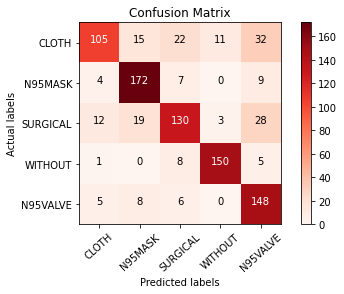

In [20]:
from numpy import vstack
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


def model_evaluation(validate_dfs):
    predictions, actuals = torch.tensor([]), torch.tensor([])
    for i, data in enumerate(val_dataloader(validate_dfs)):
        inputs, targets = data['image'], data['mask']
        targets = targets.flatten()
        output = mask_detector_cnn(inputs)
        output = torch.argmax(output,axis=1)
        predictions = torch.cat((predictions, output.flatten()), dim=0) #Concatenates the given sequence of seq tensors in the given dimension
        actuals = torch.cat((actuals, targets), dim=0)
        
    classes = ['CLOTH', 'N95MASK','SURGICAL', 'WITHOUT', 'N95VALVE']
    print(classification_report(actuals.cpu(), predictions.cpu(), digits=2, target_names=classes))
    confusion_mat = confusion_matrix(actuals.cpu().numpy(), predictions.cpu().numpy())
    plot_CNN(confusion_mat, classes)
        



model_evaluation(validate_dfs)

## prediction of our model 

mask_dataset/Cloth mask/334.jpg
Predicted :CLOTHMASK


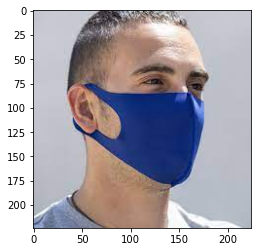

In [21]:
import random
class_mapping2 = {0: 'CLOTHMASK', 1: 'N95MASK', 2: 'SURGICALMASK', 3: 'WITHOUTMASK', 4: 'N95VALVE'}

def prediction_CNN():
    #test_df = prepare_predict_df()
    
    rand_ind = random.choice(list(range(0,32)))
    rand_sampler = torch.utils.data.RandomSampler(validate_dfs, num_samples=32, replacement=True)
    data = iter(DataLoader(validate_dfs, batch_size=32, num_workers=0, sampler=rand_sampler)).next()
    inputs,targets = data['image'], data['mask']
    output = mask_detector_cnn(inputs)
    output = torch.argmax(output,axis=1)
    print(data['path'][rand_ind])
    image = Image.open(data['path'][rand_ind])
    plt.imshow(np.asarray(image))
    print("Predicted :" + class_mapping2[output[rand_ind].tolist()])

    
prediction_CNN() 

## dumping our DataLoader and CNN model

In [23]:
import pickle
pickle.dump(DataLoader, open("mask_dataset\dataloader.pkl", 'wb'))
pickle.dump(MaskDetectorCNN(), open("mask_dataset\maskdetectorcnn.pkl", 'wb'))